In [2]:
import os
from PIL import Image
import zipfile
import numpy as np
from tqdm import tqdm
limit = 20000

# Function to resize images
def resize_images(image_dir, target_size=(64, 64), limit=20000):
    X_train = []
    image_count = 0
    valid_image_extensions = ('.jpg', '.jpeg', '.png')

    # List all image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_image_extensions)]

    # Extract the first X images
    for i, img_file in enumerate(image_files[:limit]):
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)
        img = img.convert('RGB')  # Convert to RGB
        resized_img = img.resize(target_size)  # Resize image
        img_array = np.array(resized_img) / 127.5 - 1.0  # Normalize image
        X_train.append(img_array)  # Append to X_train

        image_count += 1

    # Convert the list of images into a NumPy array for training
    return np.array(X_train)

image_dir = "_____"

# Call the function to resize images and create X_train
X_train = resize_images(image_dir, limit=limit)

print("Number of resized images:", len(X_train))

Number of resized images: 20000


In [3]:
X_train=np.array(X_train)/ 255.0 # images between -1 and 1

In [4]:
print(np.shape(X_train))

(20000, 64, 64, 3)


In [5]:
import os
import torch
# import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np


BATCH_SIZE=100

USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('mps')

# Constant to control how frequently we print train loss
print_every = 100
print('using device:', device)

using device: mps


In [6]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming X_train is your numpy array with shape (N, 64,64,3)
# Compute the overall mean and standard deviation across all images and channels
mean = np.mean(X_train, axis=(0, 1,2))
std = np.std(X_train, axis=(0, 1, 2))
print("Mean for each channel:", mean)
print("Standard deviation for each channel:", std)



X_train_normalized = transforms.Normalize(mean, std)(torch.from_numpy(X_train).permute(0, 3, 1, 2)) # (N,3,64,64)
# Convert numpy array to PyTorch TensorDataset
dataset = TensorDataset(X_train_normalized)
loader_train = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle= True )

Mean for each channel: [ 3.81852931e-05 -5.88761967e-04 -9.20390066e-04]
Standard deviation for each channel: [0.0024061  0.00224699 0.00224382]


In [7]:
import torch.nn.utils.spectral_norm as spectral_norm
#the First neural network : the Discriminator : the output should be in [0,1] ---> Fake or not Fake
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)  # [N, 64, 32, 32]
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # [N, 128, 16, 16]
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) # [N, 256, 8, 8]
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1) # [N, 512, 4, 4]

        # Output layer
        self.fc = nn.Linear(512 * 4 * 4, 1)

        # LeakyReLU :
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = self.leaky_relu(self.conv4(x))

        # Flatten the tensor and pass through a fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        # Return the sigmoid output
        return torch.sigmoid(x)

In [8]:

# The second neural network : the Generator ; the output should be an image with the shape of input data (3,64,64) and values -1,1 (because we already normalized)

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()

        # Upscale the latent vector
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)

        # ConvTranspose2d to upscale the feature maps
        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # [N, 256, 8, 8]
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # [N, 128, 16, 16]
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # [N, 64, 32, 32]
        self.conv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)     # [N, 3, 64, 64]

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc(x)

        x = x.view(x.size(0), 512, 4, 4)

        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)

        # produce images in range [-1, 1]
        x = self.tanh(self.conv4(x))

        return x

In [9]:
# My Part : GAN
class GAN(nn.Module):
    def __init__(self, latent_dim=128, lr=0.0001):
        super(GAN, self).__init__()
        self.lr = lr
        self.latent_dim = latent_dim
        # Creating the networks
        self.generator = Generator(latent_dim=self.latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        #Random noise to test the image laters
        self.validation_z = torch.randn(20, self.latent_dim, device=device, dtype=dtype)

    def forward(self, z):
        return self.generator(z)

    def plot_images(self):
        z = self.validation_z  
        sample_imgs = self.forward(z).cpu()  # Generate images 
        
        # sclale from [-1, 1] to [0, 1] 
        sample_imgs = (sample_imgs + 1) / 2.0

        fig = plt.figure(figsize=(10, 10))  
        for i in range(20):  # Plotting 20 images
            plt.subplot(4, 5, i + 1)
            plt.tight_layout()

            # Convert the image tensor to NumPy format for plt.imshow (from [C, H, W] to [H, W, C])
            img = sample_imgs[i].permute(1, 2, 0).detach().numpy()
            plt.imshow(img)  # Display the image
            plt.title("Generated Image")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')  
        
        plt.show()

In [10]:
def train_module(model, g_opt, d_opt, loader_train, epochs=1, print_every=100):
    model = model.to(device=device, dtype=dtype)  

    for e in range(epochs):
        for t, real_imgs in enumerate(loader_train):
            model.train() 
            real_imgs = real_imgs[0].to(device=device, dtype=dtype) 
            # Sample noise for Generator
            z = torch.randn(real_imgs.size(0), model.latent_dim, device=device, dtype=dtype)

            # Train the Generator
            # training the generator : max log(D(G(z))) z is noise # by maximizing we want the discriminator to return 1 (because they are all fake)
            g_opt.zero_grad()
            # Generate fake images from noise
            fake_imgs = model.generator(z)
            # Discriminator's prediction on fake images (we want it to predict 1, i.e., real)
            y_hat_fake = model.discriminator(fake_imgs)
            y_real_labels = torch.ones(fake_imgs.size(0), 1, device=device, dtype=dtype)  # Real labels (1)

            # Generator loss (we want here to fool the Discriminator, so labels are 1)
            g_loss = F.binary_cross_entropy(y_hat_fake, y_real_labels)
                
            g_loss.backward()
            g_opt.step()

            

            # Train the Discriminator
            #training the discriminator max log(D(x))+log(1-D(G(z)))

            d_opt.zero_grad()
            # 1. Train on real images
            y_hat_real = model.discriminator(real_imgs)  # Discriminator's prediction on real images
            y_real_labels = torch.ones(real_imgs.size(0), 1, device=device, dtype=dtype)  # Real labels (1)
            real_loss = F.binary_cross_entropy(y_hat_real, y_real_labels)


            fake_imgs = model.generator(z).detach()  
            y_hat_fake = model.discriminator(fake_imgs)  # Discriminator's prediction on fake images
            y_fake_labels = torch.zeros(fake_imgs.size(0), 1, device=device, dtype=dtype)  # Fake labels (0)
            fake_loss = F.binary_cross_entropy(y_hat_fake, y_fake_labels)

            # Total Discriminator loss
            d_loss = (real_loss + fake_loss) / 2
            
            d_loss.backward()
            d_opt.step()

         
            if t % print_every == 0:
                print(f'Epoch [{e}/{epochs}], Iteration [{t}/{len(loader_train)}], '
                      f'Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}')
        
        # Plot images generated by the generator :
        model.plot_images()


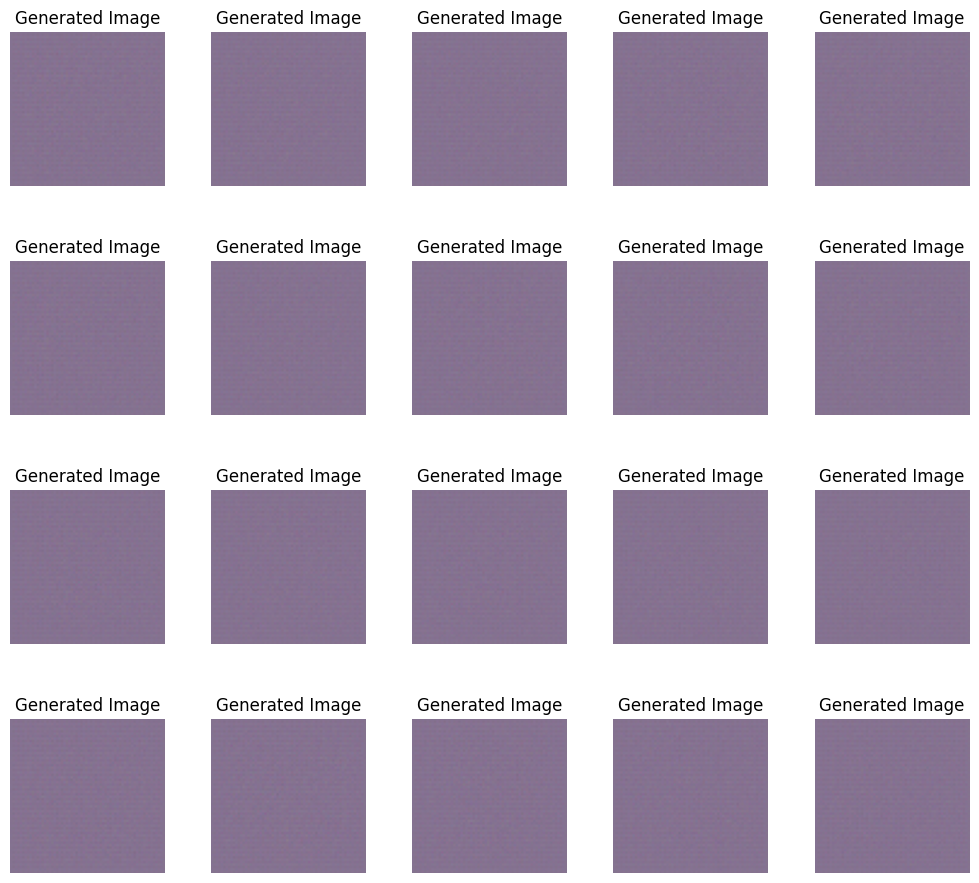

In [11]:
model = GAN()
model.plot_images()

EPOCHS = 5
lr = 0.0001

# Optimizers for generator and discriminator
opt_g = torch.optim.Adam(model.generator.parameters(), lr=lr)
opt_d = torch.optim.Adam(model.discriminator.parameters(), lr=lr)

Epoch [0/5], Iteration [0/200], Discriminator Loss: 0.6916, Generator Loss: 0.6818
Epoch [0/5], Iteration [100/200], Discriminator Loss: 0.0016, Generator Loss: 10.2065


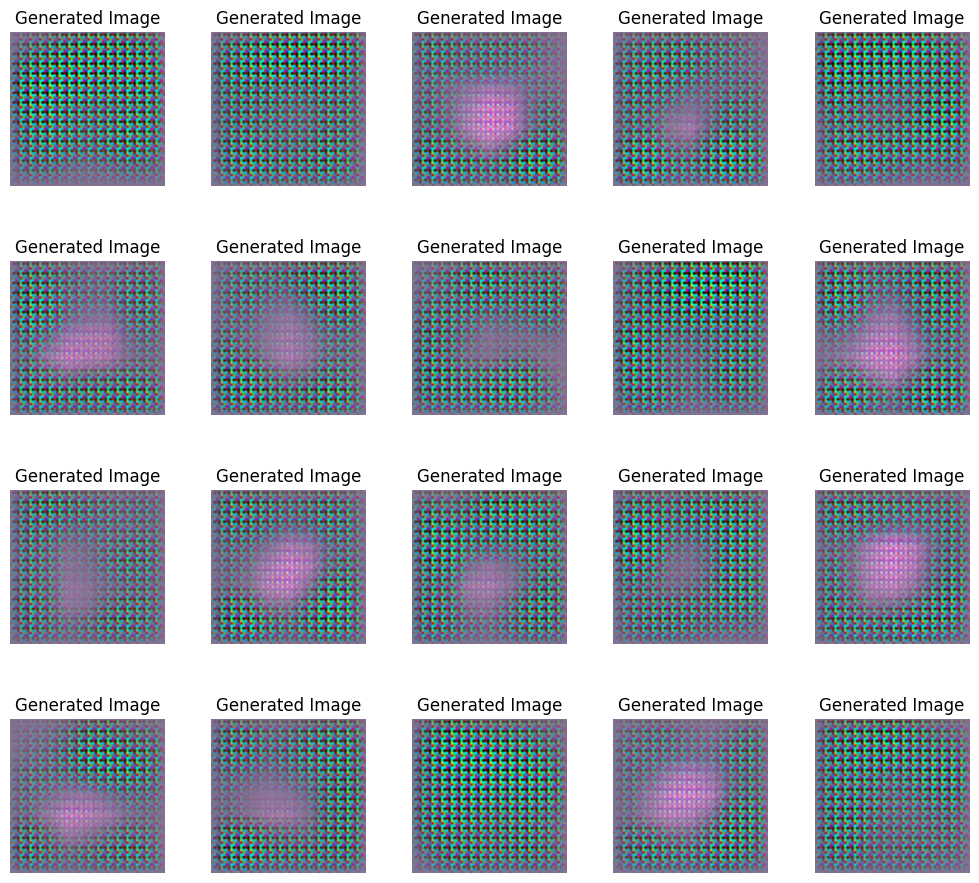

Epoch [1/5], Iteration [0/200], Discriminator Loss: 0.0019, Generator Loss: 7.5054
Epoch [1/5], Iteration [100/200], Discriminator Loss: 0.0059, Generator Loss: 8.0017


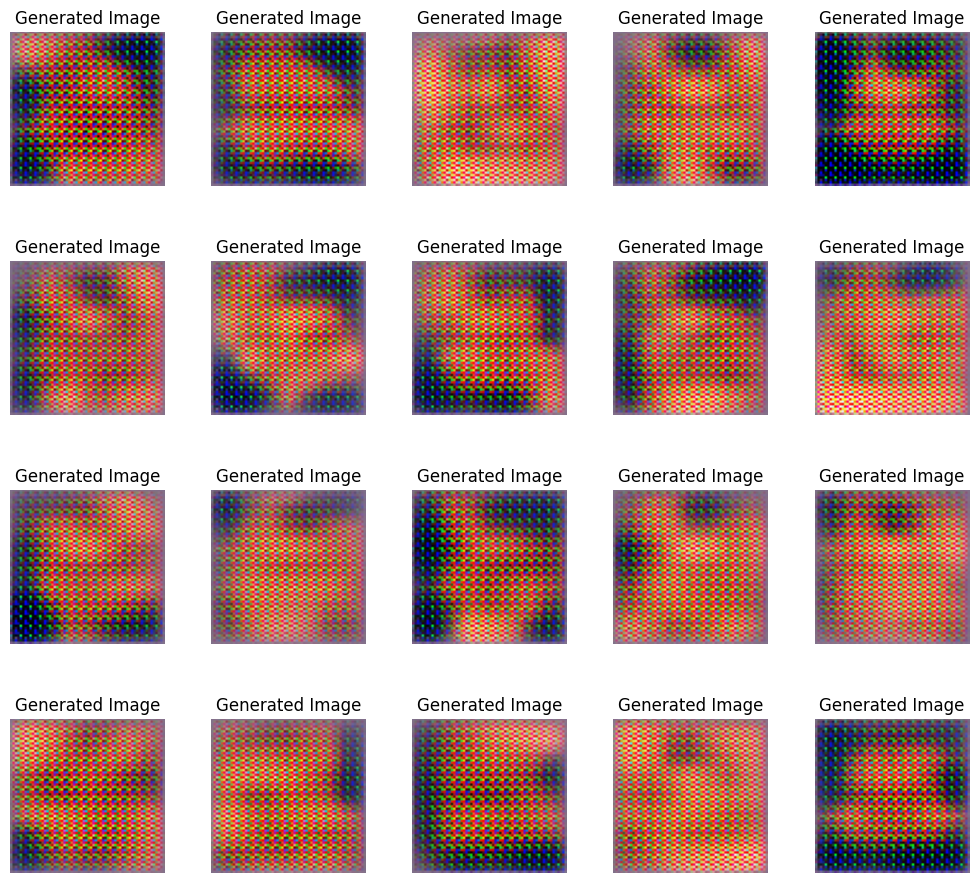

Epoch [2/5], Iteration [0/200], Discriminator Loss: 0.1284, Generator Loss: 17.2835
Epoch [2/5], Iteration [100/200], Discriminator Loss: 0.1086, Generator Loss: 3.3220


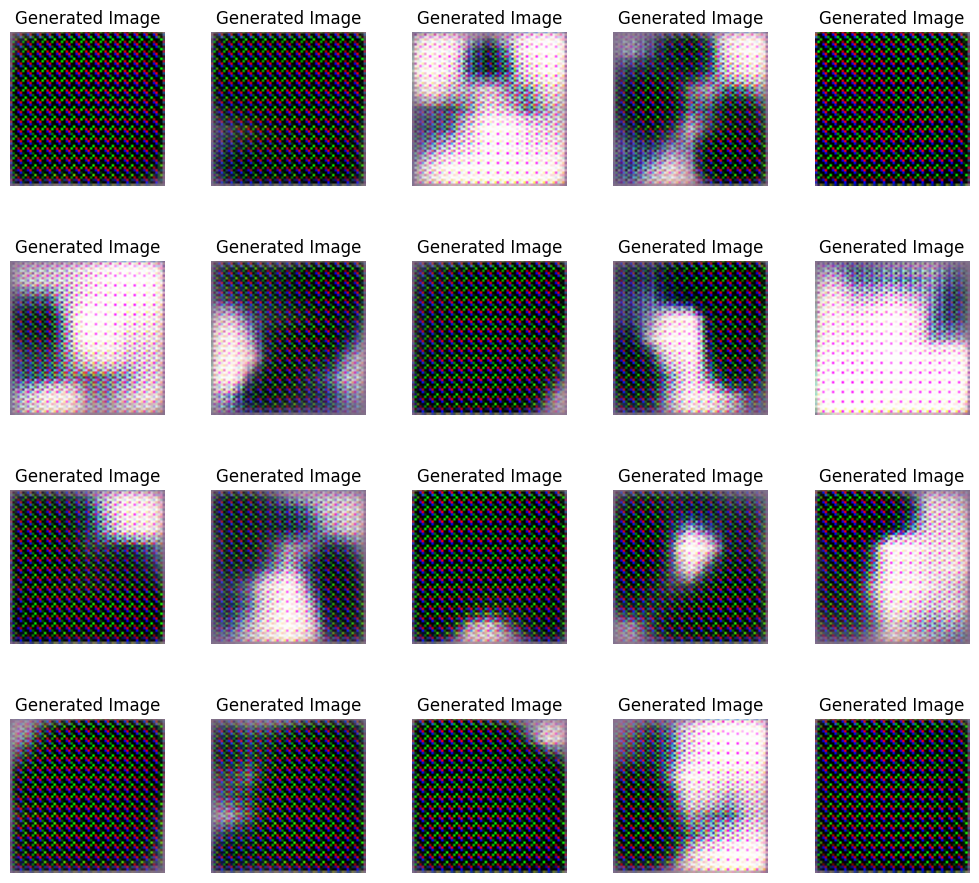

Epoch [3/5], Iteration [0/200], Discriminator Loss: 0.0279, Generator Loss: 6.6384
Epoch [3/5], Iteration [100/200], Discriminator Loss: 0.0239, Generator Loss: 8.3551


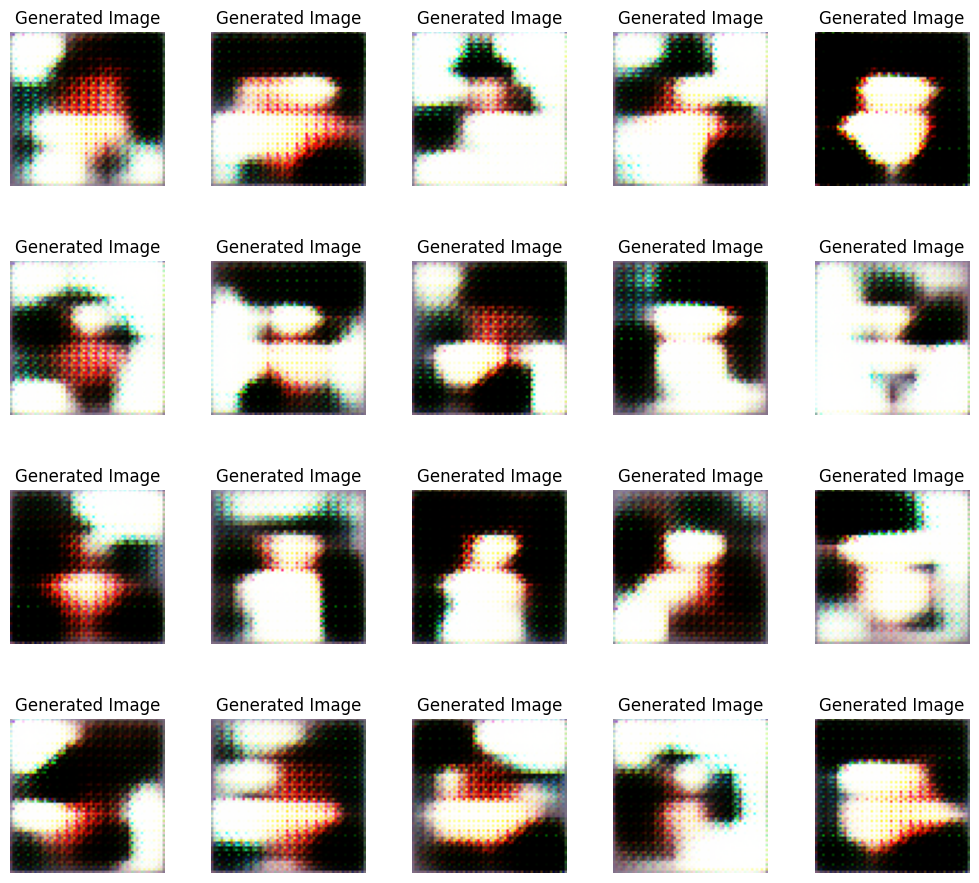

Epoch [4/5], Iteration [0/200], Discriminator Loss: 0.0851, Generator Loss: 6.6078
Epoch [4/5], Iteration [100/200], Discriminator Loss: 0.0887, Generator Loss: 5.2718


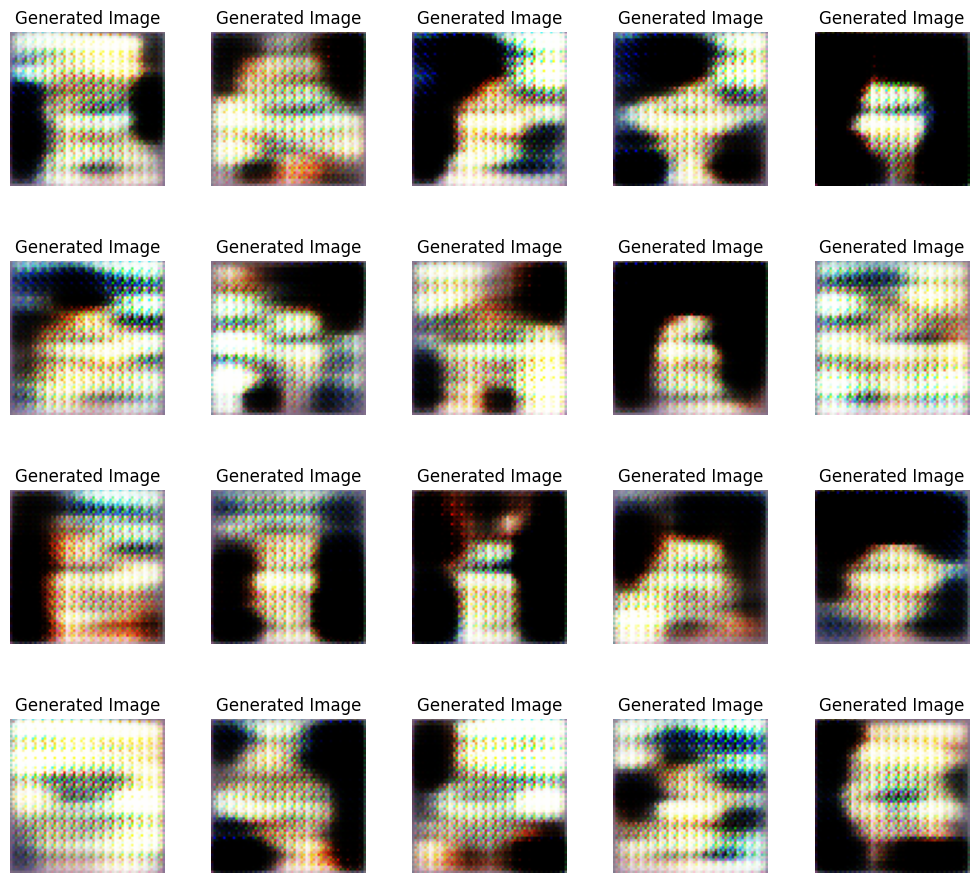

In [12]:
# Train the model
train_module(model, opt_g, opt_d, loader_train=loader_train, epochs=EPOCHS)

It's learning slowly !! I have to improve the architecture !